In [1]:
import sys
sys.path.append('..')
import ugent

In [2]:
from schrodinger import Schrodinger2D, Rectangle, Circle
import numpy as np
from math import pi

s = Schrodinger2D(lambda x, y:0, Rectangle(0, pi, 0, pi),
                  gridSize=(64, 64), maxBasisSize=32)


s.eigenvalues(50, shiftInvert=False)[:21]

[1.9999999999973093,
 4.999999999999843,
 5.000000000001867,
 7.9999999999955556,
 9.999999999996136,
 10.000000000004345,
 12.999999999997076,
 12.999999999997314,
 16.999999999994017,
 16.999999999997204,
 17.999999999998277,
 19.999999999997875,
 20.000000000000377,
 24.999999999996408,
 24.99999999999673,
 25.99999999999793,
 25.999999999998415,
 28.999999999996923,
 28.999999999997183,
 32.000000000002444,
 33.99999999999935]

In [3]:
from p_tqdm import p_map

    
def test_problem(settings, shiftInvert=False):
    exact = settings["exact"]
        
    def single_solve(params):
        n, m = params
        fds = Schrodinger2D(settings['V'], settings['domain'](), gridSize=(n,n), maxBasisSize=m)
        return params, np.abs((fds.eigenvalues(len(exact), sparse=True, shiftInvert=shiftInvert, ncv=min(n*n, int(4.4*len(exact)))) - exact)/exact)

    parameters = settings["parameters"]
    results = dict(p_map(single_solve, parameters))
    
    results_by_n = {}
    results_by_m = {}
    for (n,m), r in results.items():
        if n not in results_by_n:
            results_by_n[n] = {}
        if m not in results_by_m:
            results_by_m[m] = {}

        results_by_n[n][m] = r
        results_by_m[m][n] = r
    
    return results_by_n, results_by_m

In [85]:
import math

settings = {
    "exact": np.array(sorted([i*i + j*j for i in range(1, 100) for j in range(1, 100)])[:100]),
    "multiplicities": [i for i in range(1, 30)],
    "V": lambda x, y: 0,
    "domain": lambda: Rectangle(0, pi, 0, pi),
    "parameters": [
        (n, m) for n in [32] for m in [16, 32]
    ]
}

results_by_n, results_by_m = test_problem(settings, shiftInvert=True)

  0%|          | 0/2 [00:00<?, ?it/s]

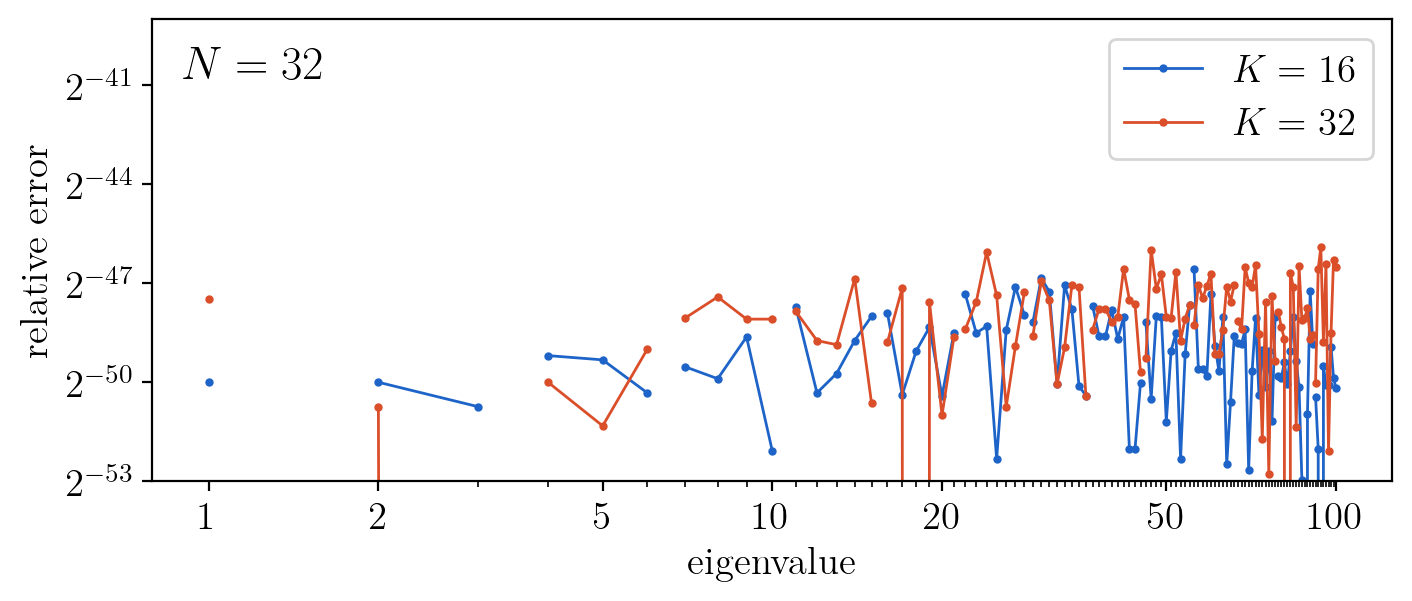

In [98]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200)
    
n = 32
rm = dict(results_by_n[n])
N = len(next(iter(rm.values())))

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=2)
ax.xaxis.set_major_locator(FixedLocator([1, 2, 5, 10, 20, 50, 100]))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_locator(FixedLocator(range(1, N)))
ax.xaxis.set_minor_formatter(FormatStrFormatter(""))
ax.set_ylim(2**-53, 2**-39)
ax.set_ylabel("relative error")
if ni == 2:
    ax.set_xlabel("eigenvalue")

mults = settings["multiplicities"]

for i, (m, r) in enumerate(sorted(rm.items())):
    j = 0

    kwargs = dict(
        label=f"$K={m}$",
        color=ugent.palet[i],
        marker='.', ls='-', lw=1, markersize=4,
    )
    for mult in mults:
        d = r[j:j+mult]
        ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
        if j == 0:
            del kwargs["label"]
        j += mult
        if j >= len(r):
            break

ax.set_title(f"$N = {n}$", y=0.835, x=0.025, loc="left")


ax.legend(loc="upper right")
    
fig.show()
plt.savefig(f"nm_test_zero_rectangle.pdf", bbox_inches="tight")

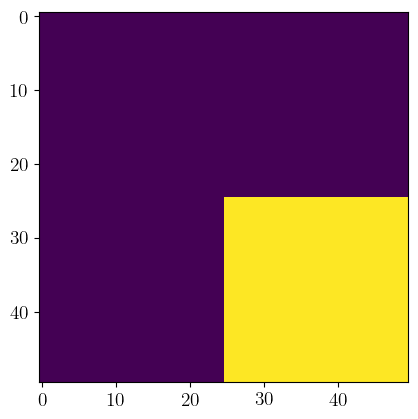

In [195]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)

dom = DomainTransform(Rectangle(0, pi, 0, pi),
                     np.eye(3))
                      #[[sqrt2div2,sqrt2div2,-pi/math.sqrt(2)],[-sqrt2div2,sqrt2div2,0],[0,0,1]])

f = np.vectorize(lambda x,y: dom.contains((x, y)), otypes=[bool])
plt.imshow(f(*np.meshgrid(x, y)))

In [196]:
dom.intersections((0, 0), (1,1))

[]

In [197]:
import math
from scipy.special import jn_zeros
from schrodinger import DomainTransform

sqrt2div2 = math.sqrt(2)/2
settings = {
    "exact": np.array(sorted([i*i + j*j for i in range(1, 100) for j in range(1, 100)])[:100]),
    "multiplicities": [i for i in range(1, 30)],
    "V": lambda x, y: 0,
    "domain": lambda: DomainTransform(
        Rectangle(0, pi, 0, pi),
        [[sqrt2div2,sqrt2div2,-pi/math.sqrt(2)],[-sqrt2div2,sqrt2div2,0],[0,0,1]]),
    "parameters": [
        (n, m) for n in [33, 49, 65] for m in [16, 32, 48] if m // 16 <= math.ceil(n / 16)
    ]
}

results_by_n, results_by_m = test_problem(settings, shiftInvert=False)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
import math
from scipy.special import jn_zeros

settings = {
    "exact": np.array(sorted(sum((list(jn_zeros(i, 50)**2)*(1 if i == 0 else 2) for i in range(0, 20)), []))[:100]),
    "multiplicities": [i for i in range(1, 30)],
    "V": lambda x, y: 0,
    "domain": lambda: Circle((0, 0), 1),
    "parameters": [
        (n, n) for n in [32, 64, 128]
    ]
}

results_by_n, results_by_m = test_problem(settings, shiftInvert=True)

  0%|          | 0/3 [00:00<?, ?it/s]

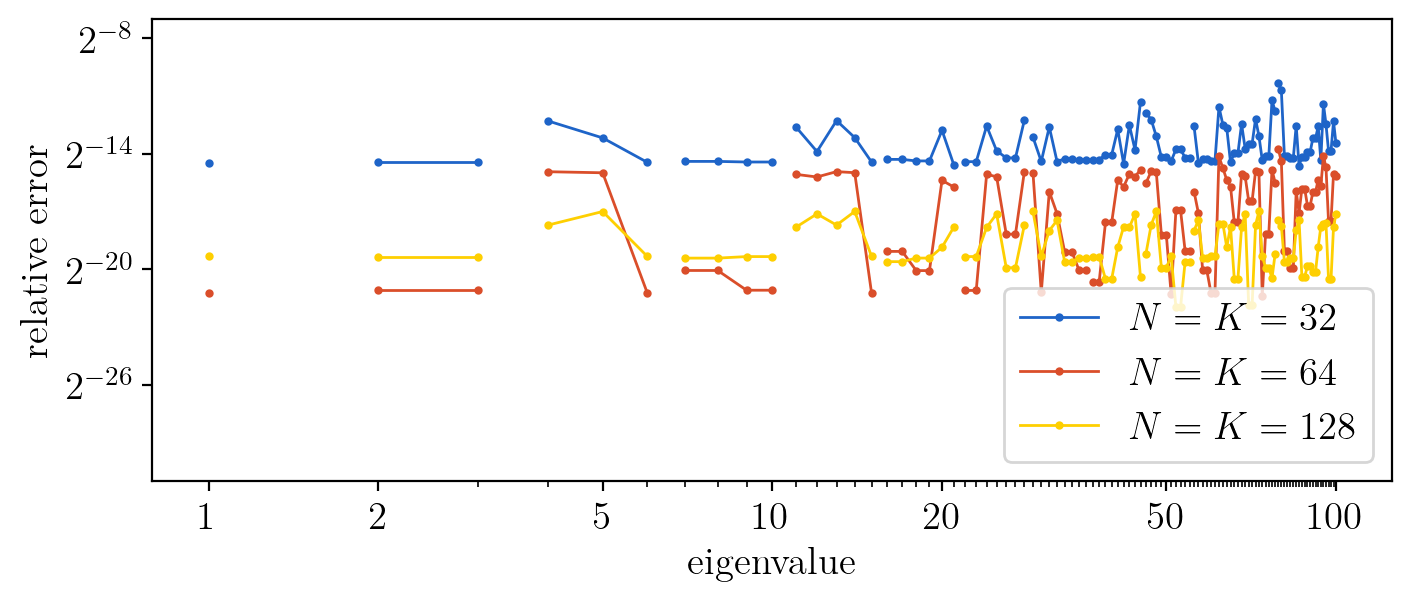

In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200)

d = {}
for i in [32, 64, 128]:
    d.update(results_by_n[i])

rm = dict(d)
N = len(next(iter(rm.values())))

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=2)
ax.xaxis.set_major_locator(FixedLocator([1, 2, 5, 10, 20, 50, 100]))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_locator(FixedLocator(range(1, N)))
ax.xaxis.set_minor_formatter(FormatStrFormatter(""))
ax.set_ylim(2**-31, 2**-7)
ax.set_ylabel("relative error")
if ni == 2:
    ax.set_xlabel("eigenvalue")

mults = settings["multiplicities"]

for i, (m, r) in enumerate(sorted(rm.items())):
    j = 0

    kwargs = dict(
        label=f"$N = K = {m}$",
        color=ugent.palet[i],
        marker='.', ls='-', lw=1, markersize=4,
    )
    for mult in mults:
        d = r[j:j+mult]
        ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
        if j == 0:
            del kwargs["label"]
        j += mult
        if j >= len(r):
            break

# ax.set_title(f"$N = {n}$", y=0.835, x=0.025, loc="left")


ax.legend(loc="lower right")
    
fig.show()
plt.savefig(f"nm_test_zero_disc.pdf", bbox_inches="tight")

In [61]:
r

array([1.95748563e-06, 2.00505910e-06, 2.00505912e-06, 1.49071118e-05,
       1.92259763e-05, 1.95364568e-06, 2.40716184e-06, 2.40716184e-06,
       2.00158056e-06, 2.00158057e-06, 1.20350239e-05, 1.75325587e-05,
       1.49329420e-05, 1.92412301e-05, 1.94819206e-06, 3.19818899e-06,
       3.19818899e-06, 2.40228217e-06, 2.40228217e-06, 2.25752186e-06,
       9.75823030e-06, 1.99462422e-06, 1.99462423e-06, 1.20902471e-05,
       1.75823367e-05, 4.39052576e-06, 4.39052576e-06, 1.49683208e-05,
       1.92588862e-05, 1.93553105e-06, 2.18635050e-06, 8.10124064e-06,
       3.19924542e-06, 3.19924543e-06, 2.38863824e-06, 2.38863824e-06,
       1.94719532e-06, 1.94719533e-06, 6.02464672e-06, 6.02464675e-06,
       2.27177454e-06, 9.78939838e-06, 1.21707564e-05, 1.76324970e-05,
       2.44911122e-06, 1.13863473e-05, 1.50040127e-05, 1.92821682e-05,
       4.40973596e-06, 4.40973596e-06, 1.92968187e-06, 7.97388976e-06,
       7.97388977e-06, 3.17920765e-06, 3.17920765e-06, 2.19087588e-06,
      

In [5]:
x = np.linspace(-5, 5, 311)
y = np.linspace(-5, 5, 311)
X, Y = np.meshgrid(x, y)

V = lambda x,y: x*x + y*y

def get_eigenfunctions(domain, start, end):
    s = Schrodinger2D(V, domain, gridSize=(64, 64), maxBasisSize=48)
    return tuple(zip(*s.eigenfunctions(end+5, sparse=True, shiftInvert=True)[start:end]))

def gramm_schmidt(m):
    rows, cols = m.shape
    r = np.zeros(m.shape)
    for i in range(cols):
        r[:, i] = m[:, i]
        for j in range(i):
            r[:, i] -= np.dot(r[:,j], m[:, i]) * r[:, j]
        r[:, i] /= np.linalg.norm(r[:, i])
    return r

In [6]:
import matplotlib.patches as patches

offset = 6
count = 4

zs = []
for i, (is_circle, domain) in enumerate([
    (False, Rectangle(-5,5, -5,5)),
    (True, Circle(5))
]):
    Es, fs = get_eigenfunctions(domain, offset, offset+count)
    print(Es)
    
    z = np.zeros((count,)+X.shape, dtype=np.float64)
    where = np.where(X*X + Y*Y < 5**2) if is_circle else np.where(X*X + Y*Y >= 0)
    for j, f in enumerate(fs):
        z[(j,) + where] = f(X[where], Y[where])
    zs.append(gramm_schmidt(z.reshape(count, -1).T).T.reshape(z.shape))

(8.000000175346074, 8.000000175346088, 8.000002442606027, 8.00000244260631)
(8.000003004584395, 8.000003004584777, 8.000007558030417, 8.000007558031994)


[5.54605503e-08 5.54607820e-08 1.42119758e-07 1.42119770e-07]


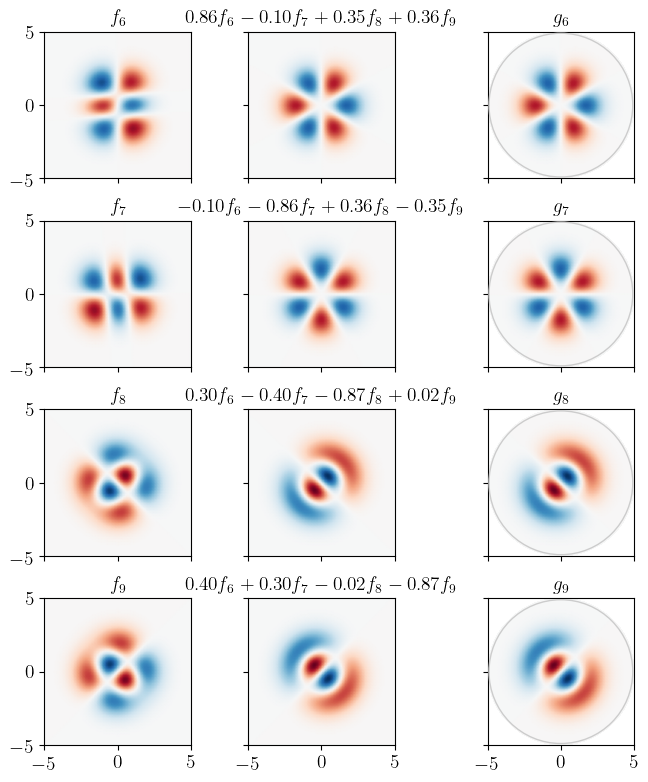

In [23]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import RegularGridInterpolator

zr, zc = zs

x_small = np.linspace(-5, 5, 97)
y_small = np.linspace(-5, 5, 97)
xg_small, yg_small = np.meshgrid(x_small, y_small)

vmax = max(np.max(np.abs(z)) for z in zs)
vmin = -vmax

vr = zr.reshape(count, -1)
vc = zc.reshape(count, -1)
lstsq_x, lstsq_residual, _, _ = np.linalg.lstsq(vr.T, vc.T,rcond=None)
print(lstsq_residual)
zro = (vr.T @ lstsq_x).T.reshape(zr.shape)

labels = [[f'f_{{{i}}}' for i in range(offset, offset+count)]]
lstsq_labels = []
for col in lstsq_x.T:
    l = ''
    for i in range(count):
        v = col[i]
        f = "%.02f"%abs(v)
        if f != '0.00':
            if v < 0:
                l += ' - ' if l else '-'
            elif l:
                l += ' + '
            l += f
            l += f' f_{{{offset + i}}}'
    lstsq_labels.append(l)
labels.append(lstsq_labels)
labels.append([f'g_{{{i}}}' for i in range(offset, offset+count)])

fig = plt.figure(figsize=(8,10))
gs = GridSpec(count+1, 4, figure=fig, width_ratios=(1,1,.05,1), height_ratios=(1,)*count + (0.1,), hspace=0.35)

axes = {}

for i, (z_labels, is_circle, z) in list(enumerate(zip(labels, [False, False, True], [zr, zro, zc]))):
    for j, label in list(enumerate(z_labels))[::-1]:
        share = {}
        if i > 0:
            share["sharex"] = axes[(j, 0)]
        if j < count - 1:
            share["sharey"] = axes[(count - 1, i)]
        ax = fig.add_subplot(gs[j, i if i < 2 else i + 1], **share)
        if i > 0:
            ax.set_yticklabels([], visible=False)
        if j < count - 1:
            ax.set_xticklabels([], visible=False)
        axes[(j, i)] = ax
        ax.set_title('$'+label+'$', size=14)
        ax.set_aspect(1)
        ax.set_xticks(ticks=[-5,0,5])
        ax.set_yticks(ticks=[-5,0,5])
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        
        interp = RegularGridInterpolator((x, y), z[j,:,:])
        
        mesh = ax.pcolormesh(x_small, y_small, interp((xg_small, yg_small)), shading='gouraud', vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu)
        if is_circle:
            mesh.set_clip_path(patches.Circle((0,0), 5, transform=ax.transData))
            ax.add_patch(patches.Circle((0,0), 4.9, fill=False, edgecolor="#cccccc", linewidth=1, zorder=10))

if False:
    ax_r_title = fig.add_subplot(gs[-1,:2])
    ax_r_title.set_title(r"$\Omega = [-5, 5]\times[-5, 5]$", size=14, y=0)
    ax_r_title.set_axis_off()

    ax_r_title = fig.add_subplot(gs[-1, 3])
    ax_r_title.set_title(r"$\Omega = B(\vb{0}, 5)$", size=14, y=0)
    ax_r_title.set_axis_off()
plt.savefig("nm_test_harmonic_eigenfunctions.png", bbox_inches='tight', dpi=500)